In [1]:
###############################################################################
#                          Libraries to use
###############################################################################

#########
#########
#########  Pyswarm package is from 2014.  Convert over to pyswarms, which has 
#########  active development.  This may help to improve convergence issues.
#########
#########


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import csv

#!pip install pyswarm
#!pip install lmfit
from pyswarm import pso
from lmfit import (Minimizer, minimize, Parameters, Parameter, report_fit, 
                   fit_report)
from scipy.integrate import odeint
from scipy import interpolate

In [2]:
## Note that pandas automatically outputs a dataframe a la R,
## only no slicing indexing allowed.  To do that, you must coerce
## to an array.

#data_url = 'https://raw.githubusercontent.com/alexbbrummer/car_T/master/cart_dex_mean_sd_gbm_single_line.csv'
data_url = "../data/pbt_second_round/car_T_dex_pbt1_pbt2_lines.csv"
data = pd.read_csv(data_url)

In [3]:
## Examine first five rows of data

data.head()

,Time (Hour),"Y(A1,A2)","SD(A1,A2)","Y(B1,B2)","SD(B1,B2)","Y(C1,C2)","SD(C1,C2)","Y(D1,D2)","SD(D1,D2)","Y(E1,E2)",...,"Y(D11,D12)","SD(D11,D12)","Y(E11,E12)","SD(E11,E12)","Y(F11,F12)","SD(F11,F12)","Y(G11,G12)","SD(G11,G12)","Y(H11,H12)","SD(H11,H12)"
0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
1,0.004722,-0.00390,0.000566,-0.00040,0.001838,0.00015,0.000495,-0.00220,0.000707,0.00120,...,-0.00110,0.000849,0.00030,0.000424,-0.00105,0.000354,-0.00060,0.000424,-0.00035,0.001626
2,0.254722,-0.06250,0.001838,-0.03030,0.001980,-0.02180,0.004243,-0.01415,0.007000,-0.00995,...,-0.01040,0.003960,-0.00495,0.001344,-0.01575,0.006152,-0.02505,0.002051,-0.01740,0.006223
3,1.289444,0.09315,0.016476,0.10135,0.003889,0.07870,0.014142,0.06665,0.000636,0.12915,...,0.09630,0.005091,0.14485,0.000919,0.14610,0.010182,0.15320,0.004808,0.22425,0.005303
4,1.539722,0.01890,0.005798,0.06200,0.002687,0.06095,0.010960,0.06450,0.000990,0.23370,...,0.07995,0.006010,0.23830,0.004101,0.23150,0.010324,0.22515,0.007990,0.32560,0.015556


In [4]:
###############################################################################
#                     ODE system Model writing
#       currently hardcoded for modeling with/without dex, without t cells
#     uses try/except to toggle use with lmfit (the try) or pyswarm (the
#     exception) and logicals to toggle for with and without dex:
#     (1) gradient along dex without t cell
###############################################################################

def f_growth(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
      # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        # Different if/elif conditions are for calling back to this function
        # at different future uses.
        if len(ps) == 2:
            rho, kappainv = ps
            c0 = 0
            kappac1 = 0
            kappac2 = 0
            theta = 0
            c3 = 0
        elif len(ps) == 3:
            rho, kappainv, c0 = ps
            kappac1 = 0
            kappac2 = 0
            theta = 0
            c3 = 0
        elif len(ps) == 1:
            c0 = ps
            rho = result_growth.params['rho'].value
            kappainv = result_growth.params['kappainv'].value
            kappac1 = 0
            kappac2 = 0
            theta = 0
            c3 = 0

    x, y = xs
    
    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g_growth(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_growth, x0, t, args=(ps, t_start))
    return x

def rms_growth(ps, *args):
    x0, ts, data, sigma = args
    model = g_growth(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    rms = np.sqrt(np.mean(res**2))
    return rms

def residual_growth(ps, *args):
    x0, ts, data, sigma = args
    model = g_growth(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    return ((model[:,0] - data)/sigma).ravel()

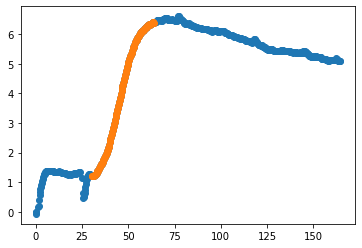

In [5]:
###############################################################################
#                     Growth (no dex) only:
###############################################################################
###############################################################################
#                     Define data to be used.
#     User must specify start, end, column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################

start_0 = 115
end_0 = 250
data_column_0 = 'Y(H1,H2)'
sigma_column_0 = 'SD(H1,H2)'
dex_0 = 0
tumor_line = 'PBT2'

data_full = np.array(data[['Time (Hour)', data_column_0]])
data_fit = np.array(data[['Time (Hour)', data_column_0]])[start_0:end_0,:]
data_sigma = np.array(data[['Time (Hour)', sigma_column_0]])[start_0:end_0,:]

t_cell_start_0 = 0.0

t = data_fit[:,0]

####### Your definition of x0 is for the initial populations,
## not the derivatives of the initial populations.
## Fix x0 definition to call on ode function to return dx/dt_0
#######
x0 = np.array([data_fit[0,1],t_cell_start_0])

plt.plot(data_full[:,0], data_full[:,1], 'o')
plt.plot(t, data_fit[:,1],'o')
plt.show()

Stopping search: Swarm best objective change less than 1e-08
[0.10999737 0.13043515] 0.5593242149556226


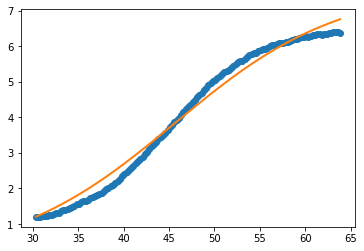

In [6]:
###############################################################################
#                     Growth (no dex) only:
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds. 
###############################################################################

# arguments are initial values of tumor cell index and t cell count,
# time domain, measured cell index values
args = (x0, t, data_fit[:,1], data_sigma[:,1])

# manually specifying lower and upper bounds, 
# range identified by trial and error.
lb = [0,0]
ub = [1,2]

#lb = [0., 0., -10]
#ub = [1., 1., 10]

# run pso() as particle swarm optimization
xopt, fopt = pso(rms_growth, lb, ub, args = args, omega=0.7, 
                 phig=1, phip=2, swarmsize=50, maxiter=1000)
print(xopt, fopt)

# plot data and fitted curves
prediction = g_growth(t, x0, xopt)
plt.plot(t, data_fit[:,1], 'o')
plt.plot(t, prediction[:,0], '-', linewidth=2)
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 135
    # variables        = 2
    chi-square         = 42.2338826
    reduced chi-square = 0.31754799
    Akaike info crit   = -152.877017
    Bayesian info crit = -147.066467
[[Variables]]
    rho:       0.10999519 +/- 0.00194903 (1.77%) (init = 0.1099974)
    kappainv:  0.13043253 +/- 0.00230030 (1.76%) (init = 0.1304351)
    c0:        0 (fixed)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappainv) =  0.903


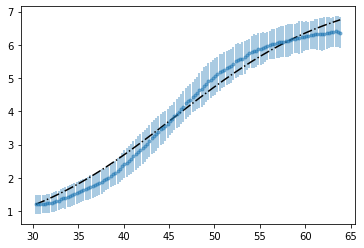

In [9]:
###############################################################################
#                     Growth (no dex) only:
###############################################################################
###############################################################################
#               Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.

params = Parameters()
# the .tolist() method is to convert the np.float64 dtype pso output into a float
# that will work with the function call to f(xs, t, ps)
params.add('rho', value=xopt[0], min=lb[0], max=ub[0], vary = True)  
params.add('kappainv', value=xopt[1], min=lb[1], max=ub[1], vary = True)
params.add('c0', value=0.0, min=-100, max=100, vary = False)
params.add('kappac1', value=0.0, min=0.0, max=40, vary = False)
params.add('kappac2', value=0.0, min=0.0, max=10, vary = False)
params.add('theta', value=0.0, min=0.0, max=10, vary = False)
params.add('c3', value=0.0, min=0.0, max=10, vary = False)

result_growth = minimize(residual_growth, params, args=(x0, t, data_fit[:,1], data_sigma[:,1]), method='leastsq')
final = data_fit[:,1] + result_growth.residual.reshape(data_fit[:,1].shape)

# Print report of fit.
print(fit_report(result_growth))
# plot data and fitted curves
#plt.plot(t, data_fit[:,1], 'o')
plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.5)
#plt.plot(t, final, '-', linewidth=2)
plt.plot(t, prediction[:,0], 'k-.')
plt.show()

In [61]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#                     ODE system Model re-writing
#       currently hardcoded for modeling with t cells using non T cell fit
#       values.  Uses try/except to toggle use with lmfit (the try) or pyswarm
 #      (the exception)
###############################################################################

def f_interaction(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
        # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        if len(ps) == 3:
            rho = result_growth.params['rho'].value
            kappainv = result_growth.params['kappainv'].value
            c0 = result_growth.params['c0'].value
            c3 = result_growth.params['c3'].value
            kappac1, kappac2, theta = ps
        elif len(ps) == 7:
            rho, kappainv, kappac1, c0, kappac2, theta, c3 = ps

    x, y = xs

    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_interaction, x0, t, args=(ps,t_start))
    return x

def rms_tcell(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    rms = np.sqrt(np.mean(res**2))
    return rms

#def weight_fun(t, w_max, t_start):
#    return (w_max-1)*(np.exp(-0.05*(t-t_start)**2))+1

def residual_tcell(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g(ts, x0, ps)
#    weights = weight_fun(ts, 50, ts[0])
#    weights = weights/np.max(weights)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    return res

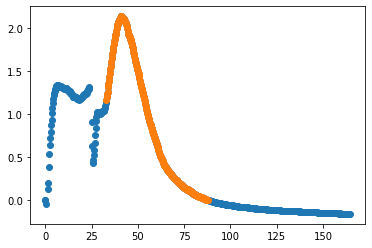

0.00395


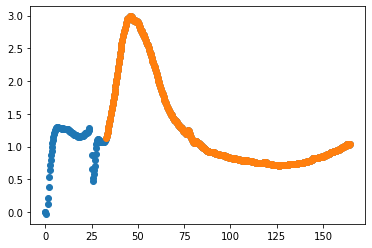

1.0382


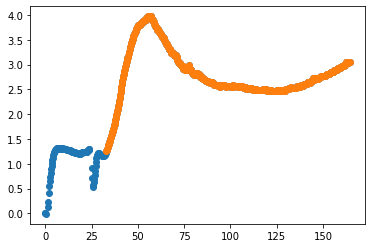

3.0577


In [62]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#                     CAR T cell treatment only:
#                     Re-define data to be used
#     User must specify start, end, data_column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################


start_t = [125, 125, 125]
end_t = [345, 652, 652]
data_column_t = ['Y(G1,G2)', 'Y(F1,F2)', 'Y(E1,E2)']
sigma_column_t = ['SD(G1,G2)', 'SD(F1,F2)', 'SD(E1,E2)']
t_cell_start_t = [0.25, 0.125, 0.05]
dex_start_t = [0, 0, 0]

for i in range(0,3):

    data_full = np.array(data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]

    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_t[i]])

    plt.plot(data_full[:,0], data_full[:,1], 'o')
    plt.plot(t, data_fit[:,1],'o')
    plt.show()
    print(data_fit[len(data_fit[:,1])-1,1])

Stopping search: Swarm best objective change less than 1e-08
[0.0251348  0.09893328 0.0838958 ] 37.25731933933715


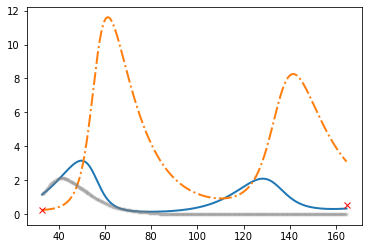

Stopping search: Swarm best objective change less than 1e-08
[0.28707309 0.04172669 0.04064932] 3.8252504391314073


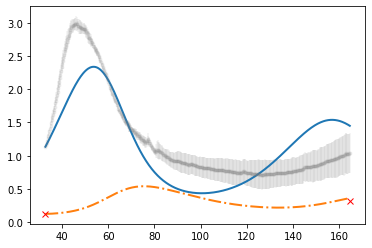

Stopping search: Swarm best objective change less than 1e-08
[0.24102658 0.04260818 0.1       ] 2.5941783491206927


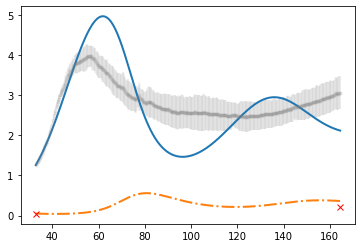

In [65]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt = []
t_fin_vec = [0.558, 0.3206, 0.2164]

for i in range(0,3):
    
    data_fit = np.array(data[['Time (Hour)', data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to data_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)
    
        
    t = data_fit[:,0]
    t_fin = t_fin_vec[i]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_t[i]])

    # arguments are initial values of tumor cell index and t cell count,
    # time domain, measured cell index values
    args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])

    # manually specifying lower and upper bounds, 
    # range identified by trial and error.
    # Comment these differently defined bounds for using pso over entire parameter space or just some

    #lb = [1e-6, -1e0, -1e3]
    #ub = [1e-4, 1e0, 1e3]
    lb = np.array([[1e-2, 1e-2, 1e-4], [1e-1, 1e-2, 5e-3], [1e-1, 1e-2, 1e-2]])
    ub = np.array([[5e0, 1e0, 1e0], [5e0, 1e-1, 1e-1], [5e0, 1e-1, 1e-1]])
    
    # run pso() as particle swarm optimization #  minfunc=1e-10, minstep=1e-10,
    xopt_temp, fopt = pso(rms_tcell, lb[i], ub[i], args = args, maxiter=1000,
                          phig= 1, phip= 2, omega = 0.7, swarmsize=50)
    xopt.append(xopt_temp)
    print(xopt[i], fopt)

    # plot data and fitted curves
    prediction = g(t, x0, xopt[i])
#    plt.plot(t, data_fit[:,1], 'o')
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')
    plt.plot(t, prediction[:,0], '-', linewidth=2)
    plt.plot(t, prediction[:,1], '-.', linewidth=2)
    plt.plot(t[0], t_cell_start_t[i], 'rx')
    plt.plot(t[-1], t_fin, 'rx')
    plt.show()
    



In [23]:
#xopt[0] = xopt[2]
#xopt[1] = xopt[2]
#xopt_copy = xopt.copy

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 113
    # data points      = 528
    # variables        = 5
    chi-square         = 6847.95295
    reduced chi-square = 13.0936003
    Akaike info crit   = 1363.05743
    Bayesian info crit = 1384.40291
[[Variables]]
    rho:       0.47086446 +/- 0.00369996 (0.79%) (init = 0.1099952)
    kappainv:  0.27050718 +/- 0.01698456 (6.28%) (init = 0.1304325)
    c0:        0 (fixed)
    c3:        0 (fixed)
    kappac1:   0.55493598 +/- 0.05645115 (10.17%) (init = 0.0251348)
    kappac2:   0.03187423 +/- 0.00249961 (7.84%) (init = 0.09893328)
    theta:     0.00181726 +/- 3.4893e-04 (19.20%) (init = 0.0838958)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, kappac2)  = -0.999
    C(kappainv, kappac2) =  0.996
    C(kappainv, kappac1) = -0.993
    C(kappac1, theta)    = -0.944
    C(kappac2, theta)    =  0.941
    C(kappainv, theta)   =  0.907
    C(rho, theta)        = -0.317


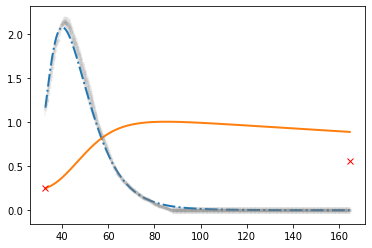

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 289
    # data points      = 528
    # variables        = 5
    chi-square         = 469.635880
    reduced chi-square = 0.89796535
    Akaike info crit   = -51.8491880
    Bayesian info crit = -30.5037066
[[Variables]]
    rho:       0.45422476 +/- 3.7499e-04 (0.08%) (init = 0.1099952)
    kappainv:  0.10885122 +/- 0.00163878 (1.51%) (init = 0.1304325)
    c0:        0 (fixed)
    c3:        0 (fixed)
    kappac1:   2.05034795 +/- 0.01888039 (0.92%) (init = 0.2870731)
    kappac2:   0.01023407 +/- 5.8058e-05 (0.57%) (init = 0.04172669)
    theta:     0.00952845 +/- 1.0321e-04 (1.08%) (init = 0.04064932)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappainv, kappac1) = -0.960
    C(rho, kappac2)      = -0.817
    C(kappac1, kappac2)  = -0.716
    C(kappainv, kappac2) =  0.595
    C(rho, kappac1)      =  0.554
    C(rho, kappainv)     = -0.462
    C(rho, theta)        = -0.416
    C(kappainv, th

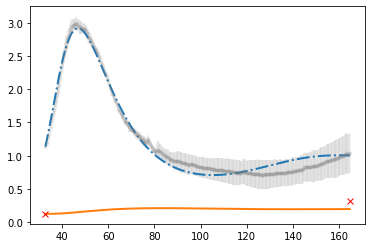

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 378
    # data points      = 528
    # variables        = 5
    chi-square         = 1126.78877
    reduced chi-square = 2.15447183
    Akaike info crit   = 410.240253
    Bayesian info crit = 431.585734
[[Variables]]
    rho:       0.17339634 +/- 0.00292946 (1.69%) (init = 0.1099952)
    kappainv:  0.12302176 +/- 8.8747e-04 (0.72%) (init = 0.1304325)
    c0:        0 (fixed)
    c3:        0 (fixed)
    kappac1:   1.36807069 +/- 0.05128004 (3.75%) (init = 0.2410266)
    kappac2:   0.03631439 +/- 0.00135723 (3.74%) (init = 0.04260818)
    theta:     0.09999932 +/- 0.00434739 (4.35%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappac1)      =  0.988
    C(kappac2, theta)    =  0.983
    C(rho, theta)        = -0.641
    C(rho, kappac2)      = -0.635
    C(kappac1, theta)    = -0.570
    C(kappac1, kappac2)  = -0.569
    C(kappainv, kappac1) = -0.499
    C(rho, kappainv)     = 

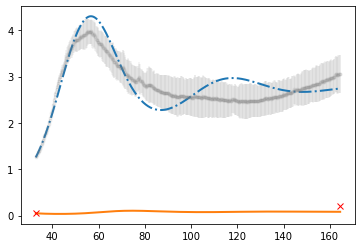

In [66]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.

start_t = [125, 125, 125]
end_t = [345, 652, 652]

result_tcell = []

for i in range(0,3):
    

    data_fit = np.array(data[['Time (Hour)', data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to data_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    t = data_fit[:,0]
    t_fin = t_fin_vec[i]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_t[i]])

    params0 = Parameters()
    # the .tolist() method is to convert the np.float64 dtype pso output into a float
    # that will work with the function call to f(xs, t, ps)
    params0.add('rho', value=result_growth.params['rho'], min=0.0, max=1, vary = True)  
    params0.add('kappainv', value=result_growth.params['kappainv'], min=0.01, max=2, vary = True)
    params0.add('c0', value=result_growth.params['c0'], min=-50, max=50, vary = False)
    params0.add('c3', value=result_growth.params['c3'], min=0, max=10, vary = False)
    params0.add('kappac1', value=xopt[i][0], min=lb[i][0], max=ub[i][0], vary = True)
    params0.add('kappac2', value=xopt[i][1], min=lb[i][1], max=ub[i][1], vary = True)
    params0.add('theta', value=xopt[i][2], min=lb[i][2], max=ub[i][2], vary = True)


    result_tcell_temp = minimize(residual_tcell, params0, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
    result_tcell.append(result_tcell_temp)
#    final = data_fit[:,1] + result_tcell[i].residual.reshape(data_fit[:,1].shape)
    prediction = g(t,x0,result_tcell[i].params)

    # Print report of fit.
    try:
        print(fit_report(result_tcell[i]))
    except:
        print('Errors not estimated')
    # plot data and fitted curves
#    plt.plot(t, data_fit[:,1], 'o')
#    plt.plot(t, final, '-', linewidth=2)
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')
    plt.plot(t,prediction[:,0], '-.', linewidth = 2)
    plt.plot(t, prediction[:,1], '-', linewidth=2)
    plt.plot(t[-1], t_fin, 'rx')
    plt.plot(t[0], t_cell_start_t[i], 'rx')
    plt.show()

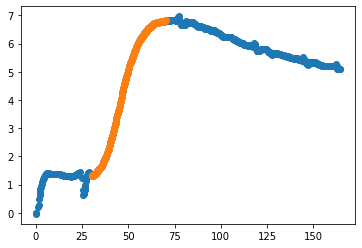

6.8299


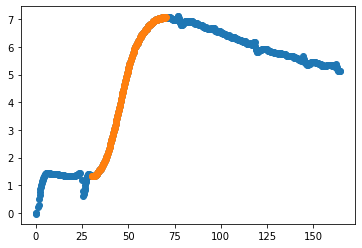

7.06805


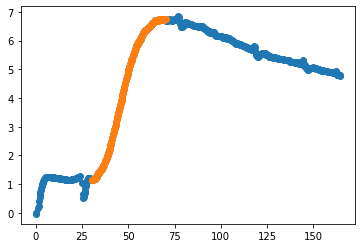

6.7424


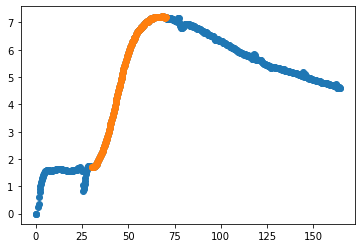

7.1968


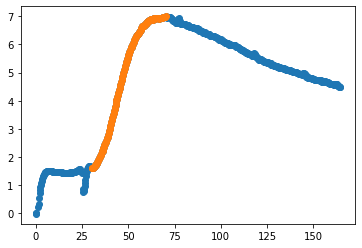

7.00185


In [67]:
###############################################################################
#                     Growth with Dex no T-cell
###############################################################################
###############################################################################
#                     Re-define data to be used.
#     User must specify start, end, data_column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################

start_gd = [115, 115, 115, 115, 115]
end_gd = [275, 275, 275, 275, 275]
data_column_gd = ['Y(H3,H4)', 'Y(H5,H6)', 'Y(H7,H8)', 'Y(H9,H10)', 'Y(H11,H12)']
sigma_column_gd = ['SD(H3,H4)', 'SD(H5,H6)', 'SD(H7,H8)', 'SD(H9,H10)', 'SD(H11,H12)']
t_cell_start_gd = [0, 0, 0, 0, 0]
dex_start_gd = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]

for i in range(0,5):
    data_full = np.array(data[['Time (Hour)', data_column_gd[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_gd[i]]])[start_gd[i]:end_gd[i],:]


    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_gd[i]])

    plt.plot(data_full[:,0], data_full[:,1], 'o')
    plt.plot(t, data_fit[:,1],'o')
    plt.show()
    print(data_fit[len(data_fit[:,1])-1,1])

Stopping search: Swarm best objective change less than 1e-08
[0.06448269] 11.692283788326787


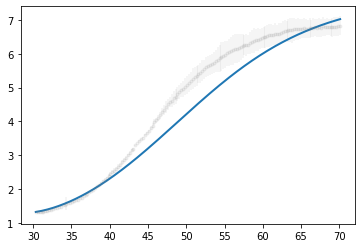

Stopping search: Swarm best objective change less than 1e-08
[0.00758524] 1.5498880558269255


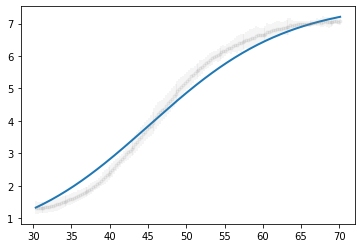

Stopping search: maximum iterations reached --> 100
[0.00928519] 1.922522349524726


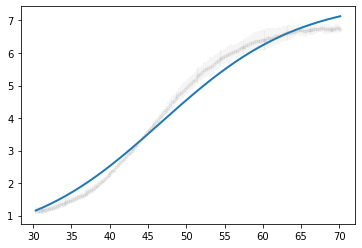

Stopping search: Swarm best objective change less than 1e-08
[0.00970077] 1.7157785145382387


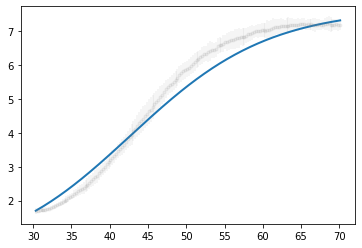

Stopping search: Swarm best objective change less than 1e-08
[0.05918134] 2.607045267311105


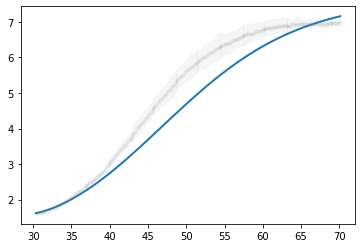

In [31]:
###############################################################################
#                     Growth no T-cell
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_gd = []


for i in range(0,5):
    data_full = np.array(data[['Time (Hour)', data_column_gd[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    

    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_gd[i]])

    # arguments are initial values of tumor cell index and t cell count,
    # time domain, measured cell index values
    args = (x0, t, data_fit[:,1], data_sigma[:,1])

    # manually specifying lower and upper bounds, 
    # range identified by trial and error.
    # Comment these differently defined bounds for using pso over entire parameter space or just some
    
    lb = np.array([[-100], [-100], [-100], [-100], [-100]])
    ub = np.array([[100], [100], [100], [100], [100]])
    #lb = np.array([[0., 0.], [0., 0.], [0., 0.]])
    #ub = np.array([[1., 1.], [1., 1.], [1., 1.]])
    #lb = np.array([[0., 0., -10], [0., 0., -10], [0., 0., -10]])
    #ub = np.array([[1., 1., 10], [1., 1., 10], [1., 1., 10]])
    
    # run pso() as particle swarm optimization
   
    xopt_temp, fopt = pso(rms_growth, lb[i], ub[i], args = args, 
                          maxiter=100, minfunc=1e-8, minstep=1e-8, phig=1, phip=2,
                         omega = 0.7)
    xopt_gd.append(xopt_temp)
    print(xopt_gd[i], fopt)

    # plot data and fitted curves
    prediction = g_growth(t, x0, xopt_gd[i])
#    plt.plot(t, data_fit[:,1], 'o')
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')
    plt.plot(t, prediction[:,0], '-', linewidth=2)
    plt.show()

In [33]:
xopt_gd

[array([0.06448269]),
 array([0.00758524]),
 array([0.00928519]),
 array([0.00970077]),
 array([0.05918134])]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 160
    # variables        = 3
    chi-square         = 8218.60154
    reduced chi-square = 52.3477805
    Akaike info crit   = 636.237045
    Bayesian info crit = 645.462566
[[Variables]]
    rho:       0.16309647 +/- 0.00428662 (2.63%) (init = 0.18)
    kappainv:  0.14356775 +/- 0.00590347 (4.11%) (init = 0.14)
    c0:        0.14000000 +/- 0.00476971 (3.41%) (init = 0.15)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       = -0.919
    C(rho, kappainv) =  0.874
    C(kappainv, c0)  = -0.629


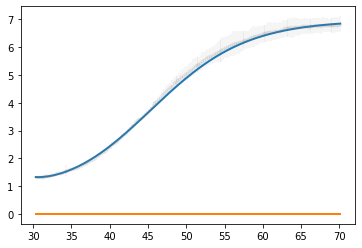

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 160
    # variables        = 3
    chi-square         = 3.44582428
    reduced chi-square = 0.02194793
    Akaike info crit   = -608.081707
    Bayesian info crit = -598.856186
[[Variables]]
    rho:       0.18162275 +/- 6.4140e-04 (0.35%) (init = 0.18)
    kappainv:  0.13960157 +/- 8.0883e-05 (0.06%) (init = 0.14)
    c0:        0.17691470 +/- 0.00152051 (0.86%) (init = 0.15)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       =  0.943
    C(rho, kappainv) =  0.692
    C(kappainv, c0)  =  0.557


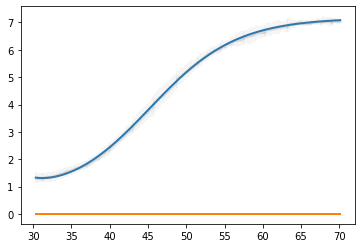

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 160
    # variables        = 3
    chi-square         = 7.54735564
    reduced chi-square = 0.04807233
    Akaike info crit   = -482.636250
    Bayesian info crit = -473.410728
[[Variables]]
    rho:       0.17968707 +/- 6.7852e-04 (0.38%) (init = 0.18)
    kappainv:  0.14574358 +/- 1.3810e-04 (0.09%) (init = 0.14)
    c0:        0.15939390 +/- 0.00155171 (0.97%) (init = 0.15)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       =  0.992
    C(rho, kappainv) =  0.579
    C(kappainv, c0)  =  0.497


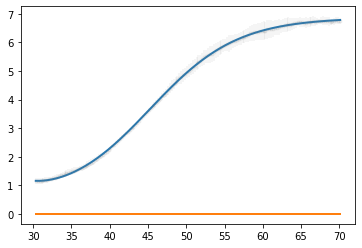

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 160
    # variables        = 3
    chi-square         = 4.57312844
    reduced chi-square = 0.02912821
    Akaike info crit   = -562.796206
    Bayesian info crit = -553.570684
[[Variables]]
    rho:       0.18450992 +/- 7.8681e-04 (0.43%) (init = 0.18)
    kappainv:  0.13681679 +/- 1.1019e-04 (0.08%) (init = 0.14)
    c0:        0.14479800 +/- 0.00132553 (0.92%) (init = 0.15)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       =  0.928
    C(rho, kappainv) =  0.655
    C(kappainv, c0)  =  0.501


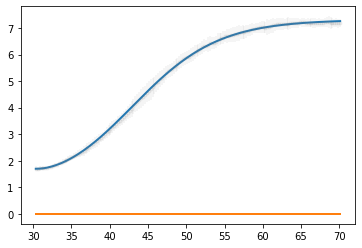

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 160
    # variables        = 3
    chi-square         = 67.8687786
    reduced chi-square = 0.43228521
    Akaike info crit   = -131.215632
    Bayesian info crit = -121.990111
[[Variables]]
    rho:       0.18725737 +/- 0.00196720 (1.05%) (init = 0.18)
    kappainv:  0.14265228 +/- 2.9944e-04 (0.21%) (init = 0.14)
    c0:        0.14000000 +/- 8.9291e-04 (0.64%) (init = 0.15)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       = -0.975
    C(rho, kappainv) =  0.465
    C(kappainv, c0)  = -0.389


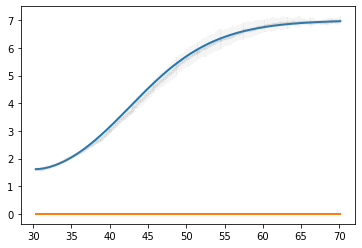

In [71]:
###############################################################################
#                     Growth no T-cell
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_growth_gd = []

for i in range(0,5):
    
    data_full = np.array(data[['Time (Hour)', data_column_gd[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_gd[i]])

    paramsgd = Parameters()
    # the .tolist() method is to convert the np.float64 dtype pso output into a float
    # that will work with the function call to f(xs, t, ps)
    #paramsgd.add('rho', value=xopt_gd[i][0], min=lb[i][0], max=ub[i][0], vary = True)  
    #paramsgd.add('kappainv', value=xopt_gd[i][1], min=lb[i][0], max=ub[i][0], vary = True)
#    paramsgd.add('rho', value=result_growth.params['rho'], min=0, max=1, vary = True)  
#    paramsgd.add('kappainv', value=result_growth.params['kappainv'], min=0, max=2, vary = True)
#    paramsgd.add('c0', value=xopt_gd[i][0], min=-100, max=100, vary = True)
    paramsgd.add('rho', value=0.18, min=0.14, max=0.2, vary = True)  
    paramsgd.add('kappainv', value=0.14, min=0.12, max=.19, vary = True)
    paramsgd.add('c0', value=0.15, min=0.14, max=0.18, vary = True)
    paramsgd.add('kappac1', value=0, min=-1, max=1, vary = False)
    paramsgd.add('kappac2', value=0, min=-1, max=1, vary = False)
    paramsgd.add('theta', value=0, min=-1, max=1, vary = False)
    paramsgd.add('c3', value=0, min=-1, max=1, vary = False)


    result_growth_gd_temp = minimize(residual_growth, paramsgd, args=(x0, t, data_fit[:,1], data_sigma[:,1]), method='leastsq')
    result_growth_gd.append(result_growth_gd_temp)
    final = data_fit[:,1] + result_growth_gd[i].residual.reshape(data_fit[:,1].shape)

    
    # Print report of fit.
    try:
        print(fit_report(result_growth_gd[i]))
    except:
        print('Errors not estimated')
    # plot data and fitted curves
#    plt.plot(t, data_fit[:,1], 'o')
    prediction = g_growth(t, x0, result_growth_gd[i].params)
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
    plt.plot(t, prediction, '-', linewidth=2)
#    plt.plot(t, final, '-', linewidth=2)
    plt.show()

In [72]:
###############################################################################
#                     T-cell with Dex
###############################################################################
###############################################################################
#                     ODE system Model re-writing
#       currently hardcoded for modeling with t cells using non T cell fit
#       values.  Uses try/except to toggle use with lmfit (the try) or pyswarm
 #      (the exception)
###############################################################################

def f_dt(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
        # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        if len(ps) == 3:
            # define result_growth_gd_now variable within loop that
            # calls this block.
            rho = result_growth_gd_now.params['rho'].value
            kappainv = result_growth_gd_now.params['kappainv'].value
            c0 = result_growth_gd_now.params['c0'].value
            theta = result_tcell_now.params['theta'].value
            kappac1, kappac2, c3 = ps
        elif len(ps) == 7:
            rho, kappainv, c0, kappac1, kappac2, theta, c3 = ps

    x, y = xs
    
    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g_dt(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_dt, x0, t, args=(ps,t_start))
    return x

def rms_dt(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g_dt(ts, x0, ps)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    rms = np.sqrt(np.mean(res**2))
    return rms
#def weight_fun(t, w_max, t_start):
#    return (w_max-1)*(np.exp(-0.0005*(t-t_start)**2))+1

#def residual_dt(ps, *args):
#    x0, ts, data = args
#    model = g_dt(ts, x0, ps)
#    weights = weight_fun(ts, 1, ts[0])
#    weights = weights/np.max(weights)
#    return ((model[:,0] - data)*weights).ravel()

def residual_dt(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g_dt(ts, x0, ps)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    return res

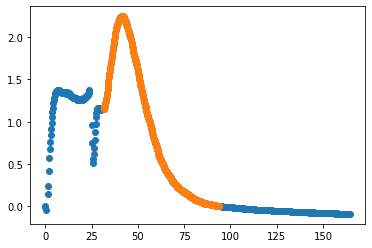

0.00565
DatasetY(G3,G4)


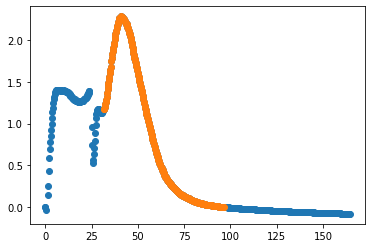

0.0005
DatasetY(G5,G6)


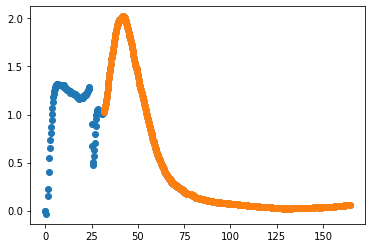

0.05885
DatasetY(G7,G8)


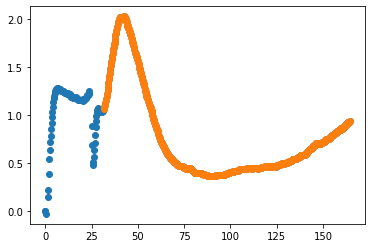

0.93305
DatasetY(G9,G10)


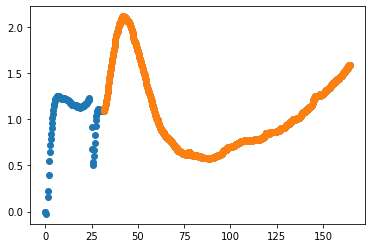

1.59215
DatasetY(G11,G12)


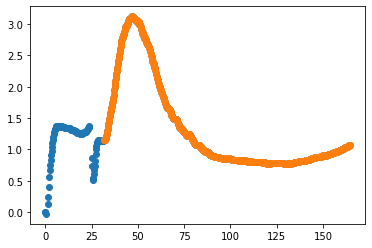

1.0735
DatasetY(F3,F4)


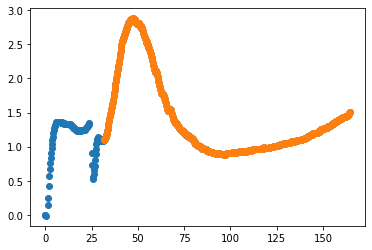

1.5019
DatasetY(F5,F6)


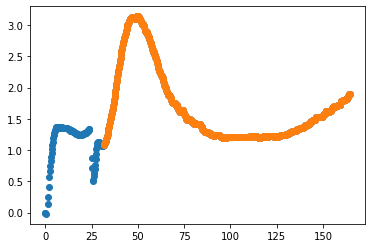

1.90215
DatasetY(F7,F8)


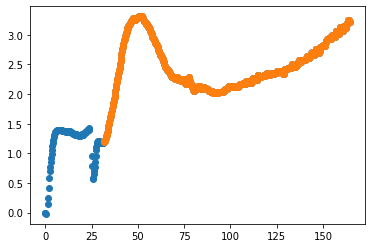

3.21205
DatasetY(F9,F10)


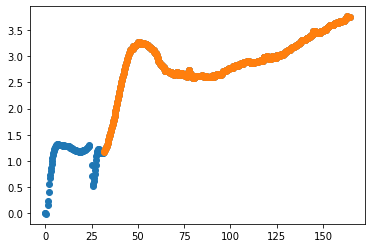

3.7528
DatasetY(F11,F12)


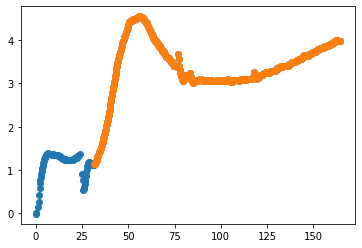

3.9831
DatasetY(E3,E4)


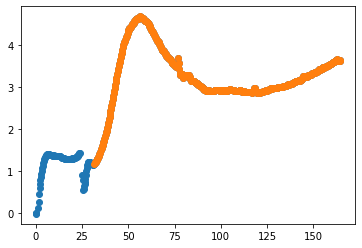

3.6536
DatasetY(E5,E6)


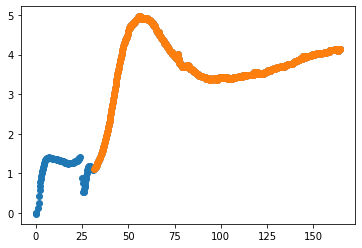

4.1503
DatasetY(E7,E8)


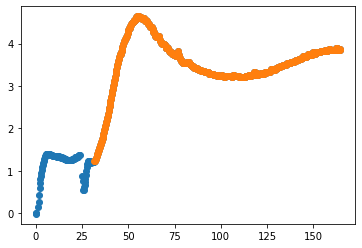

3.86325
DatasetY(E9,E10)


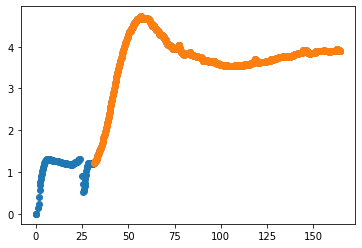

3.90175
DatasetY(E11,E12)


In [73]:
###############################################################################
#                     T-cell (0.25) with Dex
###############################################################################
###############################################################################
#                     Re-define data to be used.
#     User must specify start, end, data_column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################

## Need to decide ordering of loops for grabbing data columns.

data_column_dt = ['Y(G3,G4)', 'Y(G5,G6)', 'Y(G7,G8)', 'Y(G9,G10)', 'Y(G11,G12)',
                 'Y(F3,F4)', 'Y(F5,F6)', 'Y(F7,F8)', 'Y(F9,F10)', 'Y(F11,F12)',
                 'Y(E3,E4)', 'Y(E5,E6)', 'Y(E7,E8)', 'Y(E9,E10)', 'Y(E11,E12)']
sigma_column_dt = ['SD(G3,G4)', 'SD(G5,G6)', 'SD(G7,G8)', 'SD(G9,G10)', 'SD(G11,G12)',
                 'SD(F3,F4)', 'SD(F5,F6)', 'SD(F7,F8)', 'SD(F9,F10)', 'SD(F11,F12)',
                 'SD(E3,E4)', 'SD(E5,E6)', 'SD(E7,E8)', 'SD(E9,E10)', 'SD(E11,E12)']

start_dt = [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120]
end_dt = [370, 380, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652]
t_cell_start_dt = [0.25, 0.125, 0.05]
dex_start_dt = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
t_cell_fin_dt = [0.60505, 0.5368, 0.3343, 0.2996, 0.1787,
                 0.3651, 0.27015, 0.2957, 0.18075, 0.1003,
                 0.1839, 0.2475, 0.1127, 0.06205, 0.0827]

count = 0
for i in range(0,3):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]

        t = data_fit[:,0]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        plt.plot(data_full[:,0], data_full[:,1], 'o')
        plt.plot(t, data_fit[:,1],'o')
        plt.show()
        print(data_fit[len(data_fit[:,1])-1,1])
        print("Dataset" + str(data_column_dt[count]))
        count = count + 1

# Here we break the final fittings into three group, one for each
# T-cell concentration.  Also, will try experimenting with using the
# best fit of five as the initial guess for all.

Stopping search: Swarm best objective change less than 1e-08
[ 0.04149705  0.0602749  -0.25069778] 46.80176444974519


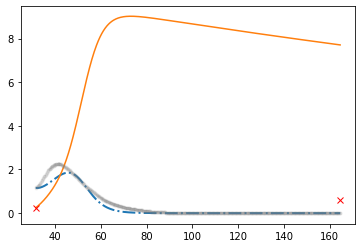

Stopping search: maximum iterations reached --> 1000
[0.65235683 0.05715548 0.23254302] 3.481168174814153


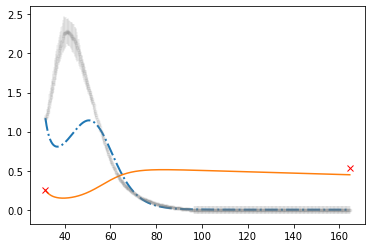

Stopping search: Swarm best objective change less than 1e-08
[0.46284305 0.05953701 0.1506934 ] 1.9951404140831484


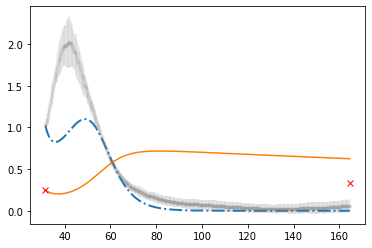

Stopping search: Swarm best objective change less than 1e-08
[0.40457637 0.14855037 1.        ] 7.109114714047079


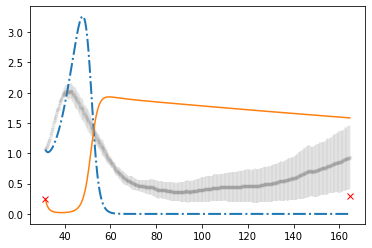

Stopping search: Swarm best objective change less than 1e-08
[0.29822838 0.2417581  1.        ] 8.165356307971802


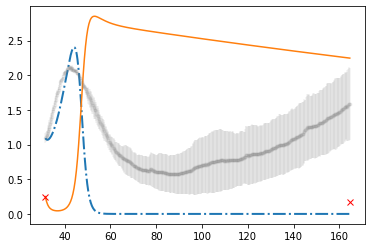

In [77]:
###############################################################################
#                     T-cell with Dex T-cell 1
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################


#    rho:       0.61203863 +/- 0.02834849 (4.63%) (init = 0.1821915)
#    kappainv:  0.31854979 +/- 0.07460323 (23.42%) (init = 0.139774)
#    c0:        0.32815551 +/- 0.04786970 (14.59%) (init = 0.1781848)
#    kappac1:   0.01803183 +/- 0.08475971 (470.06%) (init = 0.00147812)
#    kappac2:   0.04207642 +/- 0.00606276 (14.41%) (init = 0.01)
#    theta:     0.00234838 +/- 3.6048e-04 (15.35%) (init = 0.007896161)
#    c3:       -0.62702854 +/- 0.90580997 (144.46%) (init = -1.317145)


#    rho:       0.47477478 +/- 0.04347333 (9.16%) (init = 0.1785835)
#    kappainv:  0.30495567 +/- 0.28177964 (92.40%) (init = 0.144666)
#    c0:        0.23208979 +/- 0.09374913 (40.39%) (init = 0.1664343)
#    kappac1:   0.01319419 +/- 0.16413430 (1243.99%) (init = 0.01)
#    kappac2:   0.03155772 +/- 0.02345760 (74.33%) (init = 0.04045667)
#    theta:     1.0205e-04 +/- 5.1136e-04 (501.09%) (init = 0.007896161)
#    c3:       -0.73107647 +/- 2.34455215 (320.70%) (init = -0.6856248)

xopt_dt_01 = []
#xopt_dt.pop(2)

# manually specifying lower and upper bounds, 
# range identified by trial and error.
# Comment these differently defined bounds for using pso over entire parameter space or just some
lb = np.array([[5e-3, 1e-3, -1e0], [5e-3, 1e-3, -1e0], [5e-4, 1e-3, -1e0], [5e-4, 1e-5, -1e0], [5e-4, 1e-5, -1e0],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2]])
ub = np.array([[1e0, 5e-1, 1e0], [5e0, 5e-1, 1e0], [5e0, 5e-1, 1e0], [5e0, 5e-1, 1e0], [5e0, 5e-1, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0]])
#    lb = np.array([[0.1, 1e-3, -50, 1e-4, 1e-4, 1e-4], [1e-2, 1e-3, 0, 1e-5, 1e-3, 1e-3], [0.0, 0.01, -100, 1e-7, 1e-3, 1e-7]])
#    ub = np.array([[1, 1, 0, 1e-2, 1e-2, 1e-2], [1, 1, 50, 1e-3, 1e-1, 1e-1], [5, 10, 50, 1e-3, 1e1, 1e-4]])

count = 0
for i in range(0,1):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 652:
            new_time = np.array(data[['Time (Hour)']])[end_dt[j]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)
        
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]
    
        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        # arguments are initial values of tumor cell index and t cell count,
        # time domain, measured cell index values
        args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])
        result_growth_gd_now = result_growth_gd[j]
        result_tcell_now = result_tcell[i]

    
        # run pso() as particle swarm optimization
   
        xopt_temp, fopt = pso(rms_dt, lb[count], ub[count], args = args, maxiter=1000, 
                              minfunc=1e-8, minstep=1e-8, phig=1, phip=2, swarmsize=50,
                             omega = 0.7)
        xopt_dt_01.append(xopt_temp)
        print(xopt_dt_01[j], fopt)

        # plot data and fitted curves
        prediction = g_dt(t, x0, xopt_dt_01[j])
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
#        plt.plot(t, data_fit[:,1], 'o')
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-')
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
    
        count = count + 1

In [54]:
#xopt_dt_01[0] = xopt_dt_01[2]
#xopt_dt_01[1] = xopt_dt_01[2]
#xopt_dt_01[2] = xopt_dt_01[3]
#xopt_dt_01[3] = xopt_dt_01[2]
#xopt_dt_01[0] = xopt_dt_01[1]
xopt_dt_01[0][2] = -0.2
xopt_dt_01


[array([ 0.44606947,  0.05139703, -0.2       ]),
 array([ 0.44606947,  0.05139703, -0.2       ]),
 array([0.48794886, 0.05954239, 0.16142518]),
 array([0.41463819, 0.14681182, 1.        ]),
 array([0.24948707, 0.24096632, 1.        ])]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 613
    # data points      = 533
    # variables        = 5
    chi-square         = 20649.3470
    reduced chi-square = 39.1086118
    Akaike info crit   = 1959.13706
    Bayesian info crit = 1980.52966
[[Variables]]
    rho:       0.1630965 (fixed)
    kappainv:  0.1435677 (fixed)
    c0:       -2.6461e-11 +/- 3.9760e-04 (1502595772.72%) (init = -0.1)
    kappac1:   0.10387750 +/- 0.01038580 (10.00%) (init = 0.04149705)
    kappac2:   0.03579608 +/- 7.3482e-04 (2.05%) (init = 0.0602749)
    theta:     0.01178252 +/- 6.5668e-04 (5.57%) (init = 0.001817259)
    c3:       -0.21730349 +/- 0.02529810 (11.64%) (init = -0.2506978)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.998
    C(c0, kappac1)      =  0.979
    C(c0, c3)           =  0.968
    C(kappac2, c3)      =  0.811
    C(kappac1, kappac2) =  0.792
    C(c0, kappac2)      =  0.716
    C(kappac2, theta)   =  0.497


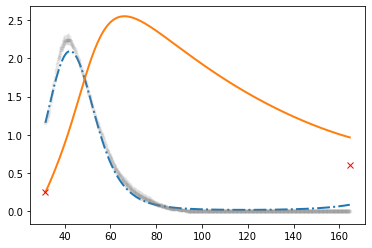

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 151
    # data points      = 533
    # variables        = 5
    chi-square         = 156.346637
    reduced chi-square = 0.29611106
    Akaike info crit   = -643.695637
    Bayesian info crit = -622.303030
[[Variables]]
    rho:       0.1816227 (fixed)
    kappainv:  0.1396016 (fixed)
    c0:       -0.08395986 +/- 0.00467444 (5.57%) (init = -0.1)
    kappac1:   0.35942675 +/- 0.01104651 (3.07%) (init = 0.6523568)
    kappac2:   0.02814380 +/- 3.5863e-04 (1.27%) (init = 0.05715548)
    theta:     0.00487139 +/- 2.5748e-04 (5.29%) (init = 0.001817259)
    c3:        0.01149205 +/- 0.00582808 (50.71%) (init = 0.232543)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.981
    C(kappac2, theta)   =  0.898
    C(c0, kappac2)      =  0.877
    C(c0, kappac1)      = -0.852
    C(c0, theta)        =  0.778
    C(c0, c3)           = -0.753
    C(kappac1, theta)   = -0.752
    C(theta, 

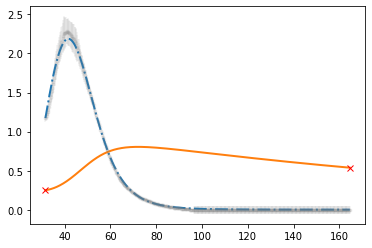

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 533
    # variables        = 5
    chi-square         = 69.2102160
    reduced chi-square = 0.13107995
    Akaike info crit   = -1078.05178
    Bayesian info crit = -1056.65917
[[Variables]]
    rho:       0.1796871 (fixed)
    kappainv:  0.1457436 (fixed)
    c0:       -0.11129405 +/- 0.00338580 (3.04%) (init = -0.1)
    kappac1:   0.38702212 +/- 0.00856501 (2.21%) (init = 0.4628431)
    kappac2:   0.02688967 +/- 3.3105e-04 (1.23%) (init = 0.05953701)
    theta:     0.00870435 +/- 1.0921e-04 (1.25%) (init = 0.001817259)
    c3:       -0.02254077 +/- 0.00482652 (21.41%) (init = 0.1506934)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.935
    C(kappac2, theta)   =  0.807
    C(c0, kappac1)      = -0.757
    C(c0, kappac2)      =  0.602
    C(c0, c3)           = -0.547
    C(c0, theta)        =  0.474
    C(kappac1, theta)   = -0.256
    C(kappac2

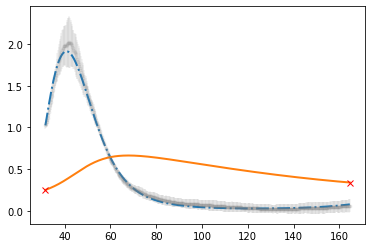

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 139
    # data points      = 533
    # variables        = 5
    chi-square         = 231.031346
    reduced chi-square = 0.43755937
    Akaike info crit   = -435.570957
    Bayesian info crit = -414.178350
[[Variables]]
    rho:       0.1845099 (fixed)
    kappainv:  0.1368168 (fixed)
    c0:       -0.52234680 +/- 0.01139805 (2.18%) (init = -0.1)
    kappac1:   2.56751720 +/- 0.05343137 (2.08%) (init = 0.4045764)
    kappac2:   0.01969818 +/- 6.3926e-04 (3.25%) (init = 0.1485504)
    theta:     0.01429358 +/- 3.7511e-04 (2.62%) (init = 0.001817259)
    c3:        0.31749627 +/- 0.00217576 (0.69%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, kappac1)      = -0.992
    C(kappac2, theta)   =  0.949
    C(c0, kappac2)      =  0.878
    C(kappac1, kappac2) = -0.830
    C(c0, theta)        =  0.783
    C(kappac1, theta)   = -0.738
    C(kappac1, c3)      =  0.592
    C(c0, c3)         

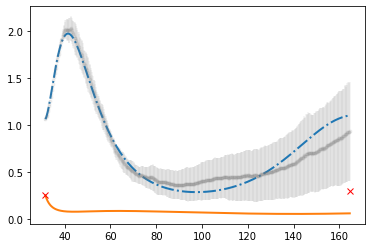

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 513
    # data points      = 533
    # variables        = 5
    chi-square         = 166.521065
    reduced chi-square = 0.31538080
    Akaike info crit   = -610.091990
    Bayesian info crit = -588.699383
[[Variables]]
    rho:       0.1872574 (fixed)
    kappainv:  0.1426523 (fixed)
    c0:       -0.38585591 +/- 0.00168262 (0.44%) (init = -0.1)
    kappac1:   1.92607967 +/- 0.01080455 (0.56%) (init = 0.2982284)
    kappac2:   0.02801914 +/- 3.3743e-04 (1.20%) (init = 0.2417581)
    theta:     0.02513224 +/- 3.4993e-04 (1.39%) (init = 0.001817259)
    c3:        0.29817166 +/- 0.00174260 (0.58%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, c3)      =  0.882
    C(c0, kappac1)      = -0.804
    C(kappac2, theta)   =  0.798
    C(kappac1, c3)      =  0.780
    C(kappac1, theta)   =  0.661
    C(theta, c3)        =  0.608
    C(kappac1, kappac2) =  0.593
    C(c0, theta)      

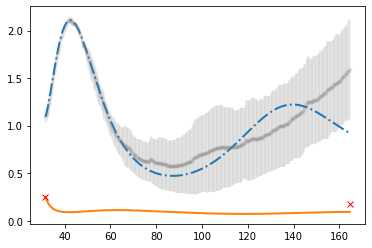

In [81]:
###############################################################################
#                     T-cell with Dex T cell 1
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_01 = []
#result_dt.pop(2)

count = 0

for i in range(0,1):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 652:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)
       
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_growth_gd[j].params['rho'], min=0., max=1, vary = False)  
        paramsdt.add('kappainv', value=result_growth_gd[j].params['kappainv'], min=0.0, max=0.5, vary = False)
#        paramsdt.add('kappainv', value=0.4, min=0.25, max=2, vary = True)
#        paramsdt.add('c0', value=result_growth_gd[j].params['c0'], min=-1e0, max=0, vary = True)
        paramsdt.add('c0', value=-0.1, min=-1e0, max=0, vary = True)
        paramsdt.add('kappac1', value=xopt_dt_01[j][0], min=lb[count][0], max=ub[count][0], vary = True)
        paramsdt.add('kappac2', value=xopt_dt_01[j][1], min=lb[count][1], max=ub[count][1], vary = True)
        paramsdt.add('theta', value=result_tcell[i].params['theta'], min= 1e-4, max=2, vary = True)
        paramsdt.add('c3', value=xopt_dt_01[count][2], min=lb[count][2], max=ub[count][2], vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
        result_dt_01.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_01[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t,x0,result_dt_01[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_01[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
#        plt.plot(t, data_fit[:,1], 'o')
        #plt.plot(t, final, '-', linewidth=2)
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

In [ ]:
###############################################################################
#                     T-cell with Dex T cell 1
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_01_new = []
#result_dt.pop(2)

count = 0

for i in range(0,1):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_dt_01_custom_values[j][0], min=8e-2, max=8e-1, vary = True)  
        paramsdt.add('kappainv', value=result_dt_01_custom_values[j][1], min=2e-1, max=5e-1, vary = True)
        paramsdt.add('c0', value=result_dt_01_custom_values[j][2], min=3e-2, max=5e-1, vary = True)
        paramsdt.add('kappac1', value=result_dt_01_custom_values[j][3], min=1e-4, max=5e-2, vary = True)
        paramsdt.add('kappac2', value=result_dt_01_custom_values[j][4], min=1e-3, max=5e-2, vary = True)
        paramsdt.add('theta', value=result_dt_01_custom_values[j][5], min=1e-4, max=1e-2, vary = True)
        paramsdt.add('c3', value=result_dt_01_custom_values[j][6], min=-2, max=-1e-1, vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin), method='leastsq')
        result_dt_01_new.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_01_new[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t,x0,result_dt_01_new[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_01_new[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    

        plt.plot(t, data_fit[:,1], 'o')
        #plt.plot(t, final, '-', linewidth=2)
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

Stopping search: Swarm best objective change less than 1e-08
[ 0.20310704  0.01645612 -0.24070912] 0.5131094570269561


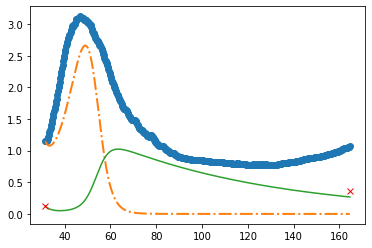

Stopping search: Swarm best objective change less than 1e-08
[ 0.21480892  0.01385063 -0.28930881] 0.571236824834866


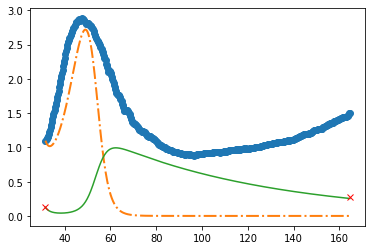

Stopping search: Swarm best objective change less than 1e-08
[ 0.19937234  0.01118793 -0.29584617] 0.620999578736864


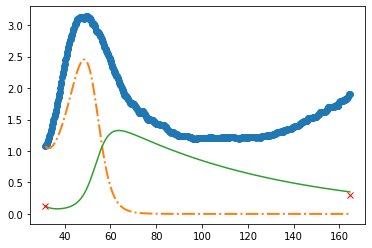

Stopping search: Swarm best objective change less than 1e-08
[ 0.17931337  0.00581061 -0.36663574] 0.6630970880196252


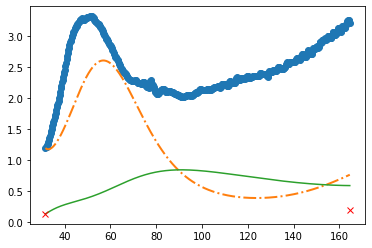

Stopping search: Swarm best objective change less than 1e-08
[ 0.16486125  0.00436283 -0.3649401 ] 0.5761943111522391


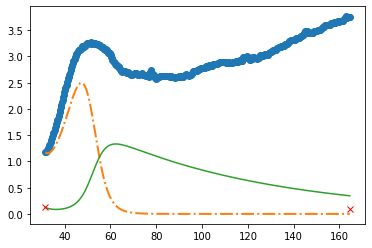

In [26]:
###############################################################################
#                     T-cell with Dex T-cell 2
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_dt_02 = []
#xopt_dt.pop(2)

# manually specifying lower and upper bounds, 
# range identified by trial and error.
# Comment these differently defined bounds for using pso over entire parameter space or just some
lb = np.array([[1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-3, 1e-3, -1e0], [1e-6, 1e-2, -1e0], [1e-6, 1e-3, -1e0], [1e-7, 1e-4, -1e0], [1e-7, 1e-4, -1e0],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2]])
ub = np.array([[1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e1, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [5e0, 1e0, 1e0], [5e0, 1e0, 1e0], [5e0, 1e0, 1e0], [5e0, 1e0, 1e0], [5e1, 1e0, 0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0]])
#    lb = np.array([[0.1, 1e-3, -50, 1e-4, 1e-4, 1e-4], [1e-2, 1e-3, 0, 1e-5, 1e-3, 1e-3], [0.0, 0.01, -100, 1e-7, 1e-3, 1e-7]])
#    ub = np.array([[1, 1, 0, 1e-2, 1e-2, 1e-2], [1, 1, 50, 1e-3, 1e-1, 1e-1], [5, 10, 50, 1e-3, 1e1, 1e-4]])

count = 5
for i in range(1,2):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]

        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]
    
        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        # arguments are initial values of tumor cell index and t cell count,
        # time domain, measured cell index values
        args = (x0, t, data_fit[:,1], t_fin)
        result_growth_gd_now = result_growth_gd[j]
        result_tcell_now = result_tcell[i]

    
        # run pso() as particle swarm optimization
   
        xopt_temp, fopt = pso(rms_dt, lb[count], ub[count], args = args, maxiter=1000, 
                              minfunc=1e-8, minstep=1e-8, phig=1, phip=2, swarmsize=50,
                             omega = 0.7)
        xopt_dt_02.append(xopt_temp)
        print(xopt_dt_02[j], fopt)

        # plot data and fitted curves
        prediction = g_dt(t, x0, xopt_dt_01[j])
        plt.plot(t, data_fit[:,1], 'o')
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-')
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
    
        count = count + 1

In [213]:
#xopt_dt_02[1] = xopt_dt_02[0]
#xopt_dt_02[1] = xopt_dt_02[3]
xopt_dt_02[2] = xopt_dt_02[1]
xopt_dt_02[3] = xopt_dt_02[4]
#xopt_dt_02

#xopt_dt_02[0][2] = 0.03
#xopt_dt_02[1][2] = 0.03
#xopt_dt_02[2][2] = 0.03
#xopt_dt_02[3][2] = 0.03
#xopt_dt_02[4][2] = 0.03
xopt_dt_02

[array([ 1.00000000e-06,  1.24071454e-02, -2.84344351e+00]),
 array([ 1.00000000e-04,  1.11545052e-02, -1.92403283e+00]),
 array([ 1.00000000e-04,  1.11545052e-02, -1.92403283e+00]),
 array([ 4.46185822e-07,  3.58029977e-03, -3.07046161e+00]),
 array([ 4.46185822e-07,  3.58029977e-03, -3.07046161e+00])]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 533
    # variables        = 4
    chi-square         = 6.74529588
    reduced chi-square = 0.01275103
    Akaike info crit   = -2321.03734
    Bayesian info crit = -2303.92326
[[Variables]]
    rho:       0.1785835 (fixed)
    kappainv:  0.144666 (fixed)
    c0:       -0.08887217 +/- 0.00286366 (3.22%) (init = 0.1664343)
    kappac1:   0.37202125 +/- 0.01103407 (2.97%) (init = 0.203107)
    kappac2:   0.01307313 +/- 6.1939e-05 (0.47%) (init = 0.01645612)
    theta:     0.01371283 (fixed)
    c3:       -0.13367487 +/- 0.00637624 (4.77%) (init = -0.2407091)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.980
    C(c0, kappac1) = -0.680
    C(c0, c3)      = -0.633
    C(c0, kappac2) =  0.309
    C(kappac2, c3) =  0.165


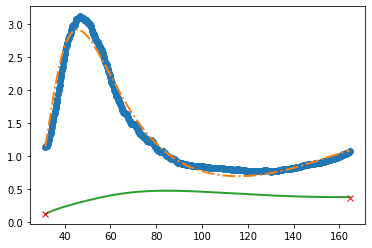

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 533
    # variables        = 4
    chi-square         = 12.1016260
    reduced chi-square = 0.02287642
    Akaike info crit   = -2009.50179
    Bayesian info crit = -1992.38771
[[Variables]]
    rho:       0.1821915 (fixed)
    kappainv:  0.139774 (fixed)
    c0:       -0.11870240 +/- 0.00495707 (4.18%) (init = 0.1781848)
    kappac1:   0.47390411 +/- 0.02337345 (4.93%) (init = 0.2148089)
    kappac2:   0.01120098 +/- 6.7849e-05 (0.61%) (init = 0.01385063)
    theta:     0.01371283 (fixed)
    c3:       -0.13408948 +/- 0.01048459 (7.82%) (init = -0.2893088)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.991
    C(c0, kappac1) = -0.819
    C(c0, c3)      = -0.797
    C(c0, kappac2) =  0.194
    C(kappac2, c3) =  0.141


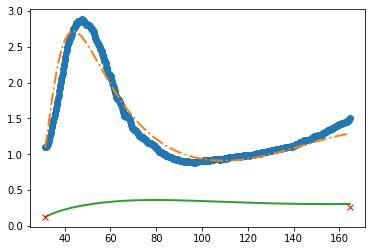

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 533
    # variables        = 4
    chi-square         = 21.1832543
    reduced chi-square = 0.04004396
    Akaike info crit   = -1711.09047
    Bayesian info crit = -1693.97638
[[Variables]]
    rho:       0.1799147 (fixed)
    kappainv:  0.1456994 (fixed)
    c0:       -0.13461181 +/- 0.00569242 (4.23%) (init = 0.1594086)
    kappac1:   0.41138521 +/- 0.02436458 (5.92%) (init = 0.1993723)
    kappac2:   0.00935136 +/- 6.6183e-05 (0.71%) (init = 0.01118793)
    theta:     0.01371283 (fixed)
    c3:       -0.15395598 +/- 0.01259760 (8.18%) (init = -0.2958462)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.991
    C(c0, kappac1) = -0.770
    C(c0, c3)      = -0.746
    C(c0, kappac2) =  0.209
    C(kappac2, c3) =  0.152


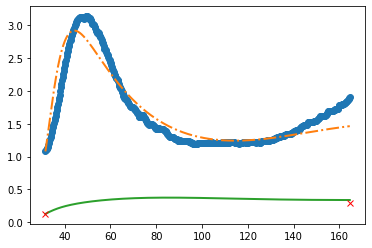

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 533
    # variables        = 4
    chi-square         = 42.3724529
    reduced chi-square = 0.08009915
    Akaike info crit   = -1341.56824
    Bayesian info crit = -1324.45416
[[Variables]]
    rho:       0.1881448 (fixed)
    kappainv:  0.1368761 (fixed)
    c0:       -0.14599809 +/- 0.01038643 (7.11%) (init = 0.1541251)
    kappac1:   0.45674856 +/- 0.04898503 (10.72%) (init = 0.1793134)
    kappac2:   0.00515655 +/- 4.6133e-05 (0.89%) (init = 0.005810613)
    theta:     0.01371283 (fixed)
    c3:       -0.17880521 +/- 0.02259895 (12.64%) (init = -0.3666357)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.997
    C(c0, kappac1)      = -0.878
    C(c0, c3)           = -0.867
    C(kappac2, c3)      =  0.156
    C(kappac1, kappac2) =  0.107


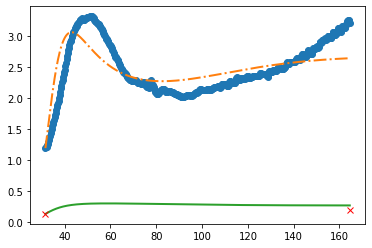

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 533
    # variables        = 4
    chi-square         = 30.5175194
    reduced chi-square = 0.05768907
    Akaike info crit   = -1516.49753
    Bayesian info crit = -1499.38344
[[Variables]]
    rho:       0.1785676 (fixed)
    kappainv:  0.141216 (fixed)
    c0:       -0.15016413 +/- 0.01336073 (8.90%) (init = 0.1373115)
    kappac1:   0.54959444 +/- 0.07777407 (14.15%) (init = 0.1648612)
    kappac2:   0.00386113 +/- 3.4689e-05 (0.90%) (init = 0.004362833)
    theta:     0.01371283 (fixed)
    c3:       -0.12672340 +/- 0.02965893 (23.40%) (init = -0.3649401)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.999
    C(c0, kappac1)      = -0.946
    C(c0, c3)           = -0.939
    C(kappac2, c3)      =  0.137
    C(kappac1, kappac2) =  0.101


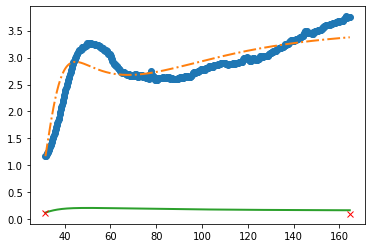

In [27]:
#### #                     T-cell with Dex T cell 2
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_02 = []
#result_dt.pop(2)

count = 5

for i in range(1,2):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_growth_gd[j].params['rho'], min=0.0, max=1, vary = False)  
        paramsdt.add('kappainv', value=result_growth_gd[j].params['kappainv'], min=1e-2, max=2, vary = False)
        paramsdt.add('c0', value=result_growth_gd[j].params['c0'], min=-10, max=10, vary = True)
        paramsdt.add('kappac1', value=xopt_dt_02[j][0], min=lb[count][0], max=ub[count][0], vary = True)
        paramsdt.add('kappac2', value=xopt_dt_02[j][1], min=lb[count][1], max=ub[count][1], vary = True)
        paramsdt.add('theta', value=result_tcell[i].params['theta'], min=-1, max=1, vary = False)
        paramsdt.add('c3', value=xopt_dt_02[j][2], min=lb[count][2], max=ub[count][2], vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin), method='leastsq')
        result_dt_02.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_02[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t,x0,result_dt_02[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_02[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves

        plt.plot(t, data_fit[:,1], 'o')
        #plt.plot(t, final, '-', linewidth=2)
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

Stopping search: Swarm best objective change less than 1e-08
[ 0.17963745  0.02079339 -0.44485066] 0.6397663613877175


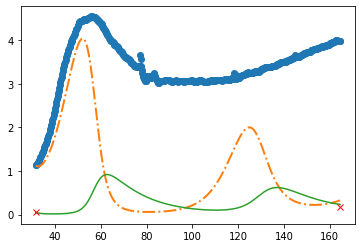

Stopping search: Swarm best objective change less than 1e-08
[ 0.20180858  0.0220958  -0.38790932] 0.4900638405196906


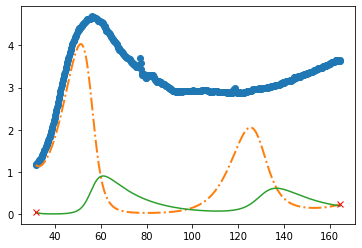

Stopping search: Swarm best objective change less than 1e-08
[ 0.18684912  0.01891245 -0.40558225] 0.6230364239857539


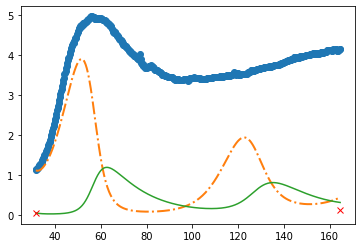

Stopping search: Swarm best objective change less than 1e-08
[ 0.23346066  0.01957736 -0.40002151] 0.4744693221229081


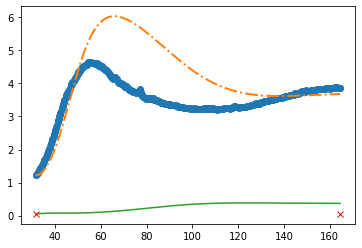

Stopping search: Swarm best objective change less than 1e-08
[ 0.20622301  0.01822233 -0.4156218 ] 0.4502582882937609


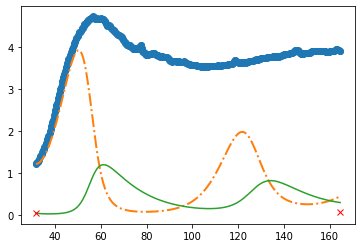

In [28]:
###############################################################################
#                     T-cell with Dex T-cell 3
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_dt_03 = []
#xopt_dt.pop(2)

# manually specifying lower and upper bounds, 
# range identified by trial and error.
# Comment these differently defined bounds for using pso over entire parameter space or just some
lb = np.array([[1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-1, 1e-3, -1e0], [1e-1, 1e-3, -1e0], [1e-1, 1e-3, -1e0], [1e-1, 1e-3, -1e0], [1e-1, 1e-3, -1e0]])
ub = np.array([[1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e1, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [5e1, 1e0, 1e0], [5e1, 1e0, 1e0], [5e1, 1e0, 1e0], [5e1, 1e0, 1e0], [5e1, 1e0, 1e0]])
#    lb = np.array([[0.1, 1e-3, -50, 1e-4, 1e-4, 1e-4], [1e-2, 1e-3, 0, 1e-5, 1e-3, 1e-3], [0.0, 0.01, -100, 1e-7, 1e-3, 1e-7]])
#    ub = np.array([[1, 1, 0, 1e-2, 1e-2, 1e-2], [1, 1, 50, 1e-3, 1e-1, 1e-1], [5, 10, 50, 1e-3, 1e1, 1e-4]])

count = 10
for i in range(2,3):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]

        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]
    
        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        # arguments are initial values of tumor cell index and t cell count,
        # time domain, measured cell index values
        args = (x0, t, data_fit[:,1], t_fin)
        result_growth_gd_now = result_growth_gd[j]
        result_tcell_now = result_tcell[i]

    
        # run pso() as particle swarm optimization
   
        xopt_temp, fopt = pso(rms_dt, lb[count], ub[count], args = args, maxiter=1000, 
                              minfunc=1e-8, minstep=1e-8, phig=1, phip=2, swarmsize=50,
                             omega = 0.7)
        xopt_dt_03.append(xopt_temp)
        print(xopt_dt_03[j], fopt)

        # plot data and fitted curves
        prediction = g_dt(t, x0, xopt_dt_01[j])
        plt.plot(t, data_fit[:,1], 'o')
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-')
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
    
        count = count + 1

In [322]:
xopt_dt_03[0] = xopt_dt_03[4]
xopt_dt_03[1] = xopt_dt_03[4]
xopt_dt_03[2] = xopt_dt_03[4]
xopt_dt_03[3] = xopt_dt_03[4]
#print(xopt_dt_03[0])
#print(xopt_dt_03[1])
#print(xopt_dt_03[2])
#print(xopt_dt_03[2])
#print(xopt_dt_03[4])
#xopt_dt_03[3][0] = 10
#xopt_dt_03[3][1] = 0.075
#xopt_dt_03[3][2] = 0.075

#xopt_dt_03[2][0] = 10
#xopt_dt_03[2][1] = 0.075
#xopt_dt_03[2][2] = 0.5

#xopt_dt_03[0][2] = 0.0)
#xopt_dt_03[1][2] = 0.03
#xopt_dt_03[2][2] = 0.03
#xopt_dt_03[3][2] = 0.03
#xopt_dt_03[4][2] = 0.03
#xopt_dt_03
#result_growth_gd[4].params

t_cell_fin_dt

[0.60505,
 0.5368,
 0.3343,
 0.2996,
 0.1787,
 0.3651,
 0.27015,
 0.2957,
 0.18075,
 0.1003,
 0.1839,
 0.2475,
 0.1127,
 0.06205,
 0.0827]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 533
    # variables        = 4
    chi-square         = 46.8751677
    reduced chi-square = 0.08861090
    Akaike info crit   = -1287.74078
    Bayesian info crit = -1270.62670
[[Variables]]
    rho:       0.1785835 (fixed)
    kappainv:  0.144666 (fixed)
    c0:       -0.04990951 +/- 0.00649690 (13.02%) (init = 0.1664343)
    kappac1:   0.41590513 +/- 0.05495301 (13.21%) (init = 0.1796374)
    kappac2:   0.01959252 +/- 8.9140e-05 (0.45%) (init = 0.02079339)
    theta:     0.06447282 (fixed)
    c3:       -0.26267392 +/- 0.02813598 (10.71%) (init = -0.4448507)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.988
    C(c0, kappac1) = -0.713
    C(c0, c3)      = -0.700
    C(c0, kappac2) =  0.177
    C(kappac2, c3) =  0.122


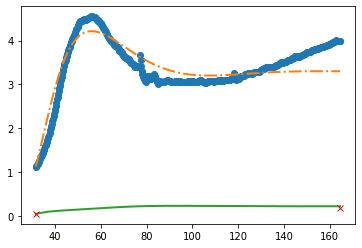

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 533
    # variables        = 4
    chi-square         = 19.2594094
    reduced chi-square = 0.03640720
    Akaike info crit   = -1761.83806
    Bayesian info crit = -1744.72397
[[Variables]]
    rho:       0.1821915 (fixed)
    kappainv:  0.139774 (fixed)
    c0:        0.00780753 +/- 0.00367464 (47.07%) (init = 0.1781848)
    kappac1:   0.39331198 +/- 0.02836176 (7.21%) (init = 0.2018086)
    kappac2:   0.02096446 +/- 6.3135e-05 (0.30%) (init = 0.0220958)
    theta:     0.06447282 (fixed)
    c3:       -0.24465059 +/- 0.01545310 (6.32%) (init = -0.3879093)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.982
    C(c0, kappac1) = -0.622
    C(c0, c3)      = -0.604
    C(c0, kappac2) =  0.239
    C(kappac2, c3) =  0.136


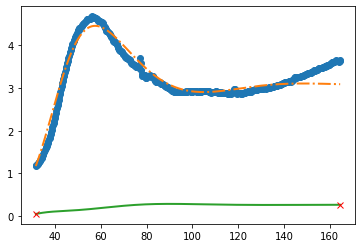

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 533
    # variables        = 4
    chi-square         = 48.4343759
    reduced chi-square = 0.09155837
    Akaike info crit   = -1270.30009
    Bayesian info crit = -1253.18601
[[Variables]]
    rho:       0.1799147 (fixed)
    kappainv:  0.1456994 (fixed)
    c0:       -0.05390922 +/- 0.00900081 (16.70%) (init = 0.1594086)
    kappac1:   0.58108169 +/- 0.11887147 (20.46%) (init = 0.1868491)
    kappac2:   0.01797770 +/- 7.8104e-05 (0.43%) (init = 0.01891245)
    theta:     0.06447282 (fixed)
    c3:       -0.16527291 +/- 0.04307245 (26.06%) (init = -0.4055822)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.994
    C(c0, kappac1) = -0.856
    C(c0, c3)      = -0.846
    C(c0, kappac2) =  0.132


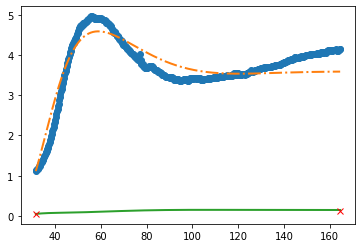

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 533
    # variables        = 4
    chi-square         = 15.7104213
    reduced chi-square = 0.02969834
    Akaike info crit   = -1870.39708
    Bayesian info crit = -1853.28300
[[Variables]]
    rho:       0.1881448 (fixed)
    kappainv:  0.1368761 (fixed)
    c0:       -0.42380506 +/- 0.01934202 (4.56%) (init = 0.1541251)
    kappac1:   15.5541520 +/- 0.97846942 (6.29%) (init = 0.2334607)
    kappac2:   0.01862548 +/- 4.8094e-05 (0.26%) (init = 0.01957736)
    theta:     0.06447282 (fixed)
    c3:        0.45747222 +/- 0.01184582 (2.59%) (init = -0.4000215)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, kappac1)      = -0.985
    C(kappac1, c3)      =  0.982
    C(c0, c3)           = -0.948
    C(c0, kappac2)      =  0.309
    C(kappac1, kappac2) = -0.238
    C(kappac2, c3)      = -0.160


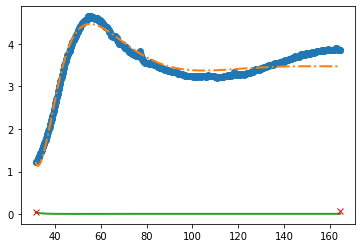

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 533
    # variables        = 4
    chi-square         = 17.7288155
    reduced chi-square = 0.03351383
    Akaike info crit   = -1805.97495
    Bayesian info crit = -1788.86086
[[Variables]]
    rho:       0.1785676 (fixed)
    kappainv:  0.141216 (fixed)
    c0:       -0.04472528 +/- 0.00857192 (19.17%) (init = 0.1373115)
    kappac1:   0.79664759 +/- 0.13482863 (16.92%) (init = 0.206223)
    kappac2:   0.01758451 +/- 4.5164e-05 (0.26%) (init = 0.01822233)
    theta:     0.06447282 (fixed)
    c3:       -0.13353323 +/- 0.03546096 (26.56%) (init = -0.4156218)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.997
    C(c0, kappac1) = -0.944
    C(c0, c3)      = -0.938


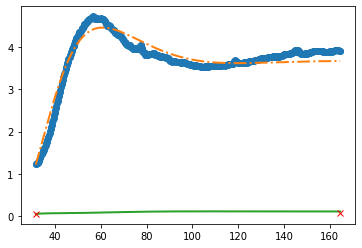

In [29]:
###############################################################################
#                     T-cell with Dex T cell 3
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_03 = []
#result_dt.pop(2)

count = 10

#new_c0 = np.array([-0.48, -0.35, -0.1199, -0.277, -0.263])

for i in range(2,3):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_growth_gd[j].params['rho'], min=0.0, max=1, vary = False)  
        paramsdt.add('kappainv', value=result_growth_gd[j].params['kappainv'], min=0.01, max=2, vary = False)
        paramsdt.add('c0', value=result_growth_gd[j].params['c0'], min = -5e-1, max = 1e0, vary = True)
#        paramsdt.add('c0', value=-0.15, min=-10, max=-1e-10, vary = True)
#        paramsdt.add('c0', value=new_c0[j], min=-10, max=-1e-10, vary = True)
        paramsdt.add('kappac1', value=xopt_dt_03[j][0], min=lb[count][0], max=ub[count][0], vary = True)
        paramsdt.add('kappac2', value=xopt_dt_03[j][1], min=lb[count][1], max=0.1, vary = True)
        paramsdt.add('theta', value=result_tcell[i].params['theta'], min=-1, max=1, vary = False)
        paramsdt.add('c3', value=xopt_dt_03[j][2], min=lb[count][2], max=ub[count][2], vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin), method='leastsq')
        result_dt_03.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_03[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t,x0,result_dt_03[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_03[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    
        plt.plot(t, data_fit[:,1], 'o')
        #plt.plot(t, final, '-', linewidth=2)
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

In [176]:
## REDO THE LAST ROUND OF FITS USING THE MANUALLY SEARCHED VALUES SAVED IN 
## final_fit_guesses_carrgo_pbt1_cart_0.05.docx.  Then merge and write everything to file.

result_dt_03_custom_values = np.array([[0.04395055, 0.1580209, -0.48457753, 13.8691004, 0.01242980, 0.01731446, 0.61066852],
                                      [0.0472214, 0.1573776, -0.36258158, 9.12953231, 0.03105238, 0.04647811, 0.52207688],
                                      [0.04387424, 0.1487601, -0.31697096, 7.88172998, 0.027954354, 0.03778579, 0.55718488],
                                      [0.01977368, 0.1106233, -0.46081639, 13.0020445, 0.06414249, 0.10999778, 0.72125277],
                                      [0.0193751, 0.1195011, -0.45848074, 9.71832353, 0.06646091, 0.11871202, 0.62749601]])

result_dt_03_custom_values

array([[ 4.39505500e-02,  1.58020900e-01, -4.84577530e-01,
         1.38691004e+01,  1.24298000e-02,  1.73144600e-02,
         6.10668520e-01],
       [ 4.72214000e-02,  1.57377600e-01, -3.62581580e-01,
         9.12953231e+00,  3.10523800e-02,  4.64781100e-02,
         5.22076880e-01],
       [ 4.38742400e-02,  1.48760100e-01, -3.16970960e-01,
         7.88172998e+00,  2.79543540e-02,  3.77857900e-02,
         5.57184880e-01],
       [ 1.97736800e-02,  1.10623300e-01, -4.60816390e-01,
         1.30020445e+01,  6.41424900e-02,  1.09997780e-01,
         7.21252770e-01],
       [ 1.93751000e-02,  1.19501100e-01, -4.58480740e-01,
         9.71832353e+00,  6.64609100e-02,  1.18712020e-01,
         6.27496010e-01]])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 552
    # variables        = 5
    chi-square         = 2.78978063
    reduced chi-square = 0.00510015
    Akaike info crit   = -2908.74696
    Bayesian info crit = -2887.17922
[[Variables]]
    rho:       0.04395055 (fixed)
    kappainv:  0.1580209 (fixed)
    c0:       -0.48457527 +/- 0.01832624 (3.78%) (init = -0.4845775)
    kappac1:   13.8697921 +/- 0.96586753 (6.96%) (init = 13.8691)
    kappac2:   0.01244061 +/- 0.00301578 (24.24%) (init = 0.0124298)
    theta:     0.01732949 +/- 0.00417375 (24.08%) (init = 0.01731446)
    c3:        0.61067786 +/- 0.01388570 (2.27%) (init = 0.6106685)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)   =  1.000
    C(kappac1, c3)      =  0.995
    C(c0, kappac1)      = -0.983
    C(c0, c3)           = -0.977
    C(c0, kappac2)      =  0.627
    C(c0, theta)        =  0.617
    C(kappac2, c3)      = -0.538
    C(thet

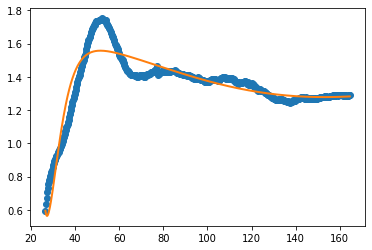

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 552
    # variables        = 5
    chi-square         = 2.82371017
    reduced chi-square = 0.00516218
    Akaike info crit   = -2902.07399
    Bayesian info crit = -2880.50625
[[Variables]]
    rho:       0.0472214 (fixed)
    kappainv:  0.1573776 (fixed)
    c0:       -0.36258158 +/- 0.01483790 (4.09%) (init = -0.3625816)
    kappac1:   9.12953231 +/- 0.79192816 (8.67%) (init = 9.129532)
    kappac2:   0.03105238 +/- 0.00167563 (5.40%) (init = 0.03105238)
    theta:     0.04647811 +/- 0.00260692 (5.61%) (init = 0.04647811)
    c3:        0.52207688 +/- 0.01775892 (3.40%) (init = 0.5220769)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)   =  0.999
    C(c0, kappac1)      = -0.994
    C(kappac1, c3)      =  0.993
    C(c0, c3)           = -0.991
    C(kappac2, c3)      = -0.466
    C(theta, c3)        = -0.457
    C(c0, kappac2)      =  0.438
    C(c0, t

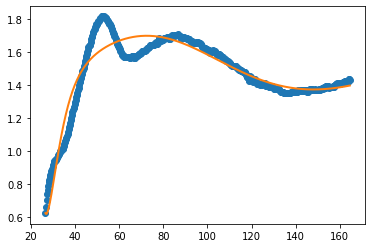

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 552
    # variables        = 5
    chi-square         = 2.55531113
    reduced chi-square = 0.00467150
    Akaike info crit   = -2957.20648
    Bayesian info crit = -2935.63874
[[Variables]]
    rho:       0.04387424 (fixed)
    kappainv:  0.1487601 (fixed)
    c0:       -0.31697298 +/- 0.01369012 (4.32%) (init = -0.316971)
    kappac1:   7.88185247 +/- 0.74656859 (9.47%) (init = 7.88173)
    kappac2:   0.02794360 +/- 8.2870e-04 (2.97%) (init = 0.02795435)
    theta:     0.03778588 +/- 0.00123036 (3.26%) (init = 0.03778579)
    c3:        0.55718801 +/- 0.01863327 (3.34%) (init = 0.5571849)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.998
    C(kappac2, theta)   =  0.996
    C(c0, kappac1)      = -0.992
    C(c0, c3)           = -0.986
    C(c0, kappac2)      =  0.467
    C(c0, theta)        =  0.440
    C(kappac1, kappac2) = -0.381
    C(kappa

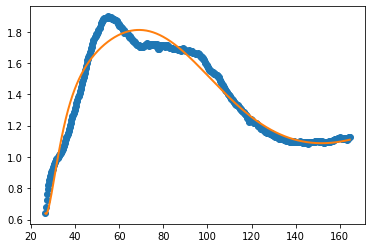

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 552
    # variables        = 5
    chi-square         = 3.68558541
    reduced chi-square = 0.00673782
    Akaike info crit   = -2755.03351
    Bayesian info crit = -2733.46577
[[Variables]]
    rho:       0.01977368 (fixed)
    kappainv:  0.1106233 (fixed)
    c0:       -0.46081639 +/- 0.01459033 (3.17%) (init = -0.4608164)
    kappac1:   13.0020445 +/- 0.92075812 (7.08%) (init = 13.00204)
    kappac2:   0.06414249 +/- 0.00213889 (3.33%) (init = 0.06414249)
    theta:     0.10999778 +/- 0.00336104 (3.06%) (init = 0.1099978)
    c3:        0.72125277 +/- 0.01111225 (1.54%) (init = 0.7212528)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)   =  0.998
    C(c0, kappac1)      = -0.976
    C(kappac1, c3)      =  0.962
    C(c0, c3)           = -0.889
    C(c0, kappac2)      =  0.681
    C(c0, theta)        =  0.666
    C(kappac1, kappac2) = -0.519
    C(kapp

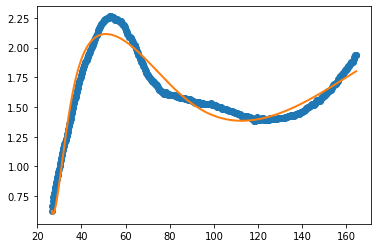

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 552
    # variables        = 5
    chi-square         = 2.24400209
    reduced chi-square = 0.00410238
    Akaike info crit   = -3028.91850
    Bayesian info crit = -3007.35075
[[Variables]]
    rho:       0.0193751 (fixed)
    kappainv:  0.1195011 (fixed)
    c0:       -0.45903001 +/- 0.01278657 (2.79%) (init = -0.4584807)
    kappac1:   9.76049867 +/- 0.71551898 (7.33%) (init = 9.718324)
    kappac2:   0.06651737 +/- 0.00240156 (3.61%) (init = 0.06646091)
    theta:     0.11880704 +/- 0.00388678 (3.27%) (init = 0.118712)
    c3:        0.62832582 +/- 0.01194828 (1.90%) (init = 0.627496)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)   =  0.999
    C(kappac1, c3)      =  0.982
    C(c0, kappac1)      = -0.978
    C(c0, c3)           = -0.927
    C(c0, kappac2)      =  0.740
    C(c0, theta)        =  0.730
    C(kappac1, kappac2) = -0.592
    C(kappac1

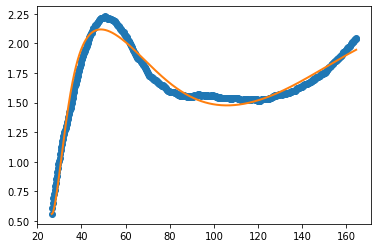

In [179]:
###############################################################################
#                     T-cell with Dex T cell 3
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_03_new = []
#result_dt.pop(2)

count = 10

for i in range(2,3):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        t = data_fit[:,0]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_dt_03_custom_values[j][0], min=1e-2, max=1e-1, vary = False)  
        paramsdt.add('kappainv', value=result_dt_03_custom_values[j][1], min=5e-2, max=5e-1, vary = False)
        paramsdt.add('c0', value=result_dt_03_custom_values[j][2], min=-1e-2, max=-1e0, vary = True)
        paramsdt.add('kappac1', value=result_dt_03_custom_values[j][3], min=1e0, max=2e1, vary = True)
        paramsdt.add('kappac2', value=result_dt_03_custom_values[j][4], min=5e-3, max=1e-1, vary = True)
        paramsdt.add('theta', value=result_dt_03_custom_values[j][5], min=5e-3, max=5e-1, vary = True)
        paramsdt.add('c3', value=result_dt_03_custom_values[j][6], min=1e-1, max=1e0, vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1]), method='leastsq')
        result_dt_03_new.append(result_dt_temp)
        final = data_fit[:,1] + result_dt_03_new[j].residual.reshape(data_fit[:,1].shape)

        # Print report of fit.
        try:
            print(fit_report(result_dt_03_new[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    

        plt.plot(t, data_fit[:,1], 'o')
        plt.plot(t, final, '-', linewidth=2)
    #    plt.plot(t, prediction[:,1]/250, '-', linewidth=2)
        plt.show()
        
        count = count + 1

In [82]:
###############################################################################
#             Write to file the output from the fit procedures.
#         Do this in two steps, assuming the file already exists
#         First: write the values from the zero t-cell fit.
#         Second: write the values from the t-cell fit as we loop through each dex
#         treatment.
###############################################################################

with open('./third_round_exports/pbt2_fit_report_file_expdex_timeshift.csv', mode= 'a', newline = '') as fit_report_file:
    ## Need nother single line report, one for growth without dex or t cell
    ## and one for interaction without dex
    
    fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    ## This block will remain on its own as we write the zero t cell zero dex fit.
    fit_report_writer.writerow([tumor_line, data_column_0, start_0, end_0, dex_0, t_cell_start_0, t_cell_start_0, 
                                result_growth.chisqr, result_growth.redchi,
                                result_growth.params['rho'].value, result_growth.params['rho'].stderr, 
                                result_growth.params['kappainv'].value, result_growth.params['kappainv'].stderr, 
                                result_growth.params['c0'].value, result_growth.params['c0'].stderr, 
                                result_growth.params['kappac1'].value, result_growth.params['kappac1'].stderr, 
                                result_growth.params['kappac2'].value, result_growth.params['kappac2'].stderr,
                                result_growth.params['theta'].value, result_growth.params['theta'].stderr, 
                                result_growth.params['c3'].value, result_growth.params['c3'].stderr])    
    
## This block will remain on its own as we write the zero dex fit.    
## Need a for loop as we have to loop through each trial for this scenario.
for i in range(0,3):
    with open('./third_round_exports/pbt2_fit_report_file_expdex_timeshift.csv', mode= 'a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    
        fit_report_writer.writerow([tumor_line, data_column_t[i], start_t[i], end_t[i], dex_start_t[i], 
                                    t_cell_start_t[i], t_fin_vec[i],
                                    result_tcell[i].chisqr, result_tcell[i].redchi,
                                    result_tcell[i].params['rho'].value, result_tcell[i].params['rho'].stderr, 
                                    result_tcell[i].params['kappainv'].value, result_tcell[i].params['kappainv'].stderr, 
                                    result_tcell[i].params['c0'].value, result_tcell[i].params['c0'].stderr, 
                                    result_tcell[i].params['kappac1'].value, result_tcell[i].params['kappac1'].stderr, 
                                    result_tcell[i].params['kappac2'].value, result_tcell[i].params['kappac2'].stderr,
                                    result_tcell[i].params['theta'].value, result_tcell[i].params['theta'].stderr, 
                                    result_tcell[i].params['c3'].value, result_tcell[i].params['c3'].stderr])

    
## Need another loop, one for growths without t cells but with dex
## and one for interactions with dex and without t cells.
for i in range(0,5):  
    with open('./third_round_exports/pbt2_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_gd[i], start_gd[i], end_gd[i], dex_start_gd[i],
                                    t_cell_start_gd[i], t_cell_start_gd[i],
                                    result_growth_gd[i].chisqr, result_growth_gd[i].redchi, 
                                    result_growth_gd[i].params['rho'].value, result_growth_gd[i].params['rho'].stderr,
                                    result_growth_gd[i].params['kappainv'].value, result_growth_gd[i].params['kappainv'].stderr,
                                    result_growth_gd[i].params['c0'].value, result_growth_gd[i].params['c0'].stderr,
                                    result_growth_gd[i].params['kappac1'].value, result_growth_gd[i].params['kappac1'].stderr,
                                    result_growth_gd[i].params['kappac2'].value, result_growth_gd[i].params['kappac2'].stderr, 
                                    result_growth_gd[i].params['theta'].value, result_growth_gd[i].params['theta'].stderr,
                                    result_growth_gd[i].params['c3'].value, result_growth_gd[i].params['c3'].stderr])

count = 0
i = 0
for j in range(0,5):
    with open('./third_round_exports/pbt2_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_dt[count], start_dt[count], end_dt[count], dex_start_dt[j], 
                                    t_cell_start_dt[i], t_cell_fin_dt[count],
                                    result_dt_01[j].chisqr, result_dt_01[j].redchi, 
                                    result_dt_01[j].params['rho'].value, result_dt_01[j].params['rho'].stderr,
                                    result_dt_01[j].params['kappainv'].value, result_dt_01[j].params['kappainv'].stderr,
                                    result_dt_01[j].params['c0'].value, result_dt_01[j].params['c0'].stderr,
                                    result_dt_01[j].params['kappac1'].value, result_dt_01[j].params['kappac1'].stderr,
                                    result_dt_01[j].params['kappac2'].value, result_dt_01[j].params['kappac2'].stderr, 
                                    result_dt_01[j].params['theta'].value, result_dt_01[j].params['theta'].stderr,
                                    result_dt_01[j].params['c3'].value, result_dt_01[j].params['c3'].stderr])
        count = count + 1

count = 5
i = 1
for j in range(0,5):
    with open('./third_round_exports/pbt2_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_dt[count], start_dt[count], end_dt[count], dex_start_dt[j], 
                                    t_cell_start_dt[i], t_cell_fin_dt[count],
                                    result_dt_02[j].chisqr, result_dt_02[j].redchi, 
                                    result_dt_02[j].params['rho'].value, result_dt_02[j].params['rho'].stderr,
                                    result_dt_02[j].params['kappainv'].value, result_dt_02[j].params['kappainv'].stderr,
                                    result_dt_02[j].params['c0'].value, result_dt_02[j].params['c0'].stderr,
                                    result_dt_02[j].params['kappac1'].value, result_dt_02[j].params['kappac1'].stderr,
                                    result_dt_02[j].params['kappac2'].value, result_dt_02[j].params['kappac2'].stderr, 
                                    result_dt_02[j].params['theta'].value, result_dt_02[j].params['theta'].stderr,
                                    result_dt_02[j].params['c3'].value, result_dt_02[j].params['c3'].stderr])
        count = count + 1

count = 10
i = 2
for j in range(0,5):
    with open('./third_round_exports/pbt2_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_dt[count], start_dt[count], end_dt[count], dex_start_dt[j],
                                    t_cell_start_dt[i], t_cell_fin_dt[count],
                                    result_dt_03[j].chisqr, result_dt_03[j].redchi, 
                                    result_dt_03[j].params['rho'].value, result_dt_03[j].params['rho'].stderr,
                                    result_dt_03[j].params['kappainv'].value, result_dt_03[j].params['kappainv'].stderr,
                                    result_dt_03[j].params['c0'].value, result_dt_03[j].params['c0'].stderr,
                                    result_dt_03[j].params['kappac1'].value, result_dt_03[j].params['kappac1'].stderr,
                                    result_dt_03[j].params['kappac2'].value, result_dt_03[j].params['kappac2'].stderr, 
                                    result_dt_03[j].params['theta'].value, result_dt_03[j].params['theta'].stderr,
                                    result_dt_03[j].params['c3'].value, result_dt_03[j].params['c3'].stderr])
        count = count + 1



NameError: name 'result_dt_02' is not defined